In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [2]:
import sys
sys.path.append('..')
import warnings
def warn(message = None, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn

In [3]:
import pandas as pd
import numpy as np
import time
import datetime as dt
from pathlib import Path
import time
#custom
from data_functions import make_date_to_MYR
from diabetes_onset import( process_canary,
get_tc, in_canary, diabet_onset, not_first_month_diabetes, 
                           match_data_per_month, 
                           filter_first_month_diabetes,
                           matched_population, 
                           propensity_func,
                           nearest_neighbor_func, 
                           random_matching_func, agglomerative )

from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.random.seed(seed = 0)

In [ ]:
%%time
pp_str = 'Pre_Matching_DATA/'

treated2 = pd.read_pickle(pp_str+'treated2.p')
controls = pd.read_pickle(pp_str+'controls.p')
pmpm =pd.read_pickle(pp_str+'pmpm.p')
#random_controls = pd.read_pickle('tempHybridSelectionMoreData/random.p')

In [ ]:
pmpm.head(0)

#### Hierarchical Clustering
> Divide the Treated population in two clusters and study the <strong>Onset of Diabetes Onset</strong> separately in each of the clusters

In [5]:
columns_to_match_hier = ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT']

treated0, treated1, model, link_matr,  clustermapdat = agglomerative(treated2.copy(), columns_to_match_hier )

#### Visualization of the clusters created in the previous step with a clustermap

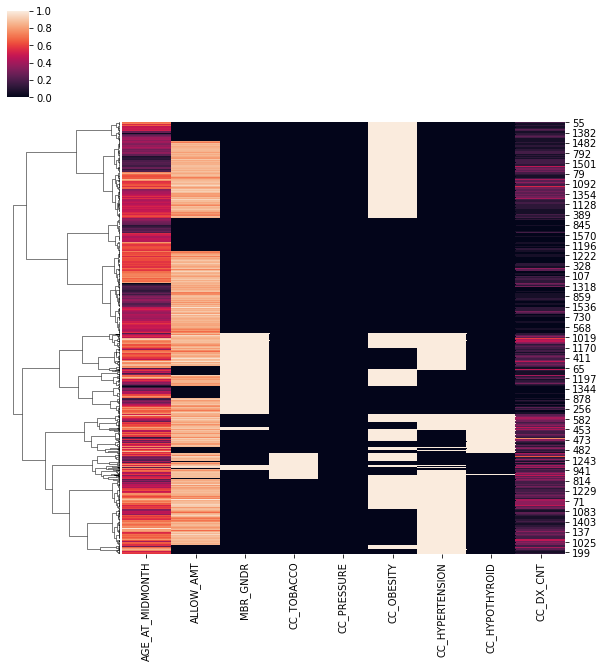

In [6]:
g = sns.clustermap(clustermapdat, method = 'ward', standard_scale=1, row_linkage = link_matr, col_cluster = False)

#### For each of the two clusters formed from the Treated patients form a matched population from the controls.
<div style="background:Aliceblue"> We use hier matching as our matching function</div>

In [7]:
#cols = list(col for col in treated2.columns if col not in ['PERS_ID', 'MYR'])
#columns_to_match = cols
columns_to_match =  ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6','LOB']

In [8]:
%%time

#columns_to_match = columns_to_match + ['IP_BIN2', 'ER_BIN2']
#hier_cols = ['IP_BIN2', 'ER_BIN2', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6']
match_on = ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE2']
hier_cols = ['IP_BIN6', 'ER_BIN6']
hier_range = [1,1]
exact_match_dict = {'IP_BIN6':[0,1,2], 'ER_BIN6':[0,1,2], 'LOB':None}
nnr_func_args = {'match_on':match_on, 'hier_cols':hier_cols,
                        'hier_range':hier_range, 'neighbors_per_treated': 5,
                 'onset': "CC_DIABETES", "onset_val" : 0, 'exact_match': True, 'exact_match_dict': exact_match_dict}
matched0, matched_data0 = matched_population(treated0.copy(), 
                                           controls.copy(),
                                           nearest_neighbor_func, 
                                           nnr_func_args)

matched1, matched_data1 = matched_population(treated1.copy(), 
                                           controls.copy(),
                                           nearest_neighbor_func, 
                                           nnr_func_args)

Mathcing Function: nearest_neighbor_func
hERE
After filtering control ids are:328522 before they were:354792
IP_BIN6 [0, 1, 2]
ER_BIN6 [0, 1, 2]
LOB None
There were no matches for 0 out of 820 patients
Mathcing Function: nearest_neighbor_func
hERE
After filtering control ids are:328522 before they were:354792
IP_BIN6 [0, 1, 2]
ER_BIN6 [0, 1, 2]
LOB None
There were no matches for 1 out of 784 patients
CPU times: user 52min 56s, sys: 34min 4s, total: 1h 27min 1s
Wall time: 1h 27min 1s


### Save data

In [9]:
Path('./tempNNhierAgglo').mkdir(exist_ok = True)
p = './tempNNhierAgglo/'
matched_data0.to_pickle(p+'match0.p')
matched_data1.to_pickle(p+'match1.p')
treated0.to_pickle(p+'treated0.p')
treated1.to_pickle(p+'treated1.p')

In [16]:
pmpm2 = pmpm
try:
    pmpm2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
except:
    pass

In [17]:
from utils import statistics_first_month, p_val, stat_matrices 

### List containing all numerical columns

In [18]:
all_columns = list(set(col for col in pmpm.columns)-set(['PERS_ID', 'MYR','MEDICAID_LOB']))

### Stats First Month(Treated and Matched Controls)

In [19]:
%%time
tr_desc0, treated_first_month0 = statistics_first_month(treated0, all_columns, return_array = True)
con_desc0, controls_first_month0 = statistics_first_month(matched_data0, all_columns, return_array = True)

tr_desc1, treated_first_month1 = statistics_first_month(treated1, all_columns, return_array = True)
con_desc1, controls_first_month1 = statistics_first_month(matched_data1, all_columns, return_array = True)

CPU times: user 4.12 s, sys: 11.6 ms, total: 4.13 s
Wall time: 4.13 s


### Stats First Month(General Pop and Random)

In [20]:
%%time
pmpm_desc = statistics_first_month(pmpm2, all_columns)
random_desc = statistics_first_month(random_controls, all_columns)

CPU times: user 2min 31s, sys: 7.74 s, total: 2min 39s
Wall time: 2min 39s


In [21]:
%%time
conds_first0, full_first0 = stat_matrices(tr_desc0, con_desc0, pmpm_desc, random_desc, columns = columns_to_match)
conds_firstAllCols0, full_firstAllCols0 = stat_matrices(tr_desc0, con_desc0, pmpm_desc, random_desc, columns = all_columns)

conds_first1, full_first1 = stat_matrices(tr_desc1, con_desc1, pmpm_desc, random_desc, columns = columns_to_match)
conds_firstAllCols1, full_firstAllCols1 = stat_matrices(tr_desc1, con_desc1, pmpm_desc, random_desc, columns = all_columns)

CPU times: user 55.2 ms, sys: 1.72 ms, total: 56.9 ms
Wall time: 54.7 ms


## Statistics on matching date

In [22]:
conds_first0.round(3)

Treated Matched Controls Test-TC        General Population   Random
                    mean             mean  t-stat   pval               mean     mean
AGE_AT_MIDMONTH   53.735           53.838  -0.220  0.826             44.311   47.606
ALLOW_AMT        833.251          744.209   0.781  0.435           1065.926  648.803
MBR_GNDR           0.402            0.411  -0.435  0.664              0.443    0.431
CC_TOBACCO         0.120            0.108   0.973  0.331              0.074    0.098
CC_PRESSURE        0.002            0.002   0.577  0.564              0.007    0.007
CC_OBESITY         0.455            0.436   0.983  0.326              0.109    0.228
CC_HYPERTENSION    0.635            0.599   1.936  0.053              0.208    0.249
CC_HYPOTHYROID     0.185            0.148   2.686  0.007              0.047    0.063
CC_DX_CNT          3.538            3.462   0.868  0.386              1.824    2.344
ACUTE2             0.062            0.055   0.777  0.437              0.063    0.052
ACUTE6             0.152            0.148   0.238  0.812              0.063    0.153
IP_BIN6            0.046            0.045   0.187  0.851              0.021    0.047
ER_BIN6            0.113            0.111   0.129  0.898              0.047    0.116
LOB                0.948            0.946   0.156  0.876              0.756    0.788

In [23]:
conds_first1.round(3)

Treated Matched Controls Test-TC        General Population   Random
                    mean             mean  t-stat   pval               mean     mean
AGE_AT_MIDMONTH   46.514           46.624  -0.223  0.823             44.311   47.606
ALLOW_AMT        547.843          514.492   0.629  0.529           1065.926  648.803
MBR_GNDR           0.000            0.000     NaN    NaN              0.443    0.431
CC_TOBACCO         0.000            0.006  -2.262  0.024              0.074    0.098
CC_PRESSURE        0.000            0.001  -0.651  0.515              0.007    0.007
CC_OBESITY         0.458            0.441   0.869  0.385              0.109    0.228
CC_HYPERTENSION    0.000            0.009  -2.696  0.007              0.208    0.249
CC_HYPOTHYROID     0.000            0.004  -1.786  0.074              0.047    0.063
CC_DX_CNT          1.837            1.825   0.180  0.857              1.824    2.344
ACUTE2             0.014            0.014   0.052  0.958              0.063    0.052
ACUTE6             0.069            0.069  -0.029  0.977              0.063    0.153
IP_BIN6            0.009            0.007   0.636  0.525              0.021    0.047
ER_BIN6            0.062            0.064  -0.144  0.885              0.047    0.116
LOB                0.957            0.955   0.251  0.802              0.756    0.788

### Statistics Over all dates (treated, controls)

In [24]:
%%time
tr_desc0A = treated0[all_columns].describe().loc[['mean', 'std', 'count']].T
tr_desc0A['count'] = tr_desc0A['count'].astype(int)

con_desc0A = matched_data0[all_columns].describe().loc[['mean', 'std', 'count']].T
con_desc0A['count'] = con_desc0A['count'].astype(int)

tr_desc1A = treated1[all_columns].describe().loc[['mean', 'std', 'count']].T
tr_desc1A['count'] = tr_desc1A['count'].astype(int)

con_desc1A = matched_data1[all_columns].describe().loc[['mean', 'std', 'count']].T
con_desc1A['count'] = con_desc1A['count'].astype(int)

CPU times: user 1.06 s, sys: 0 ns, total: 1.06 s
Wall time: 1.06 s


### Statistics Over all dates (general population, Random)

In [25]:
%%time
pmpm_descA = pmpm2[all_columns].describe().loc[['mean', 'std', 'count']].T
pmpm_descA['count'] = pmpm_descA['count'].astype(int)

random_descA = random_controls[all_columns].describe().loc[['mean', 'std', 'count']].T
random_descA['count'] = random_descA['count'].astype(int)

CPU times: user 29.3 s, sys: 2.2 s, total: 31.5 s
Wall time: 31.5 s


In [26]:
%%time
conds0, full0 = stat_matrices(tr_desc0A, con_desc0A, pmpm_descA, random_descA, columns = columns_to_match)
conds_AllCols0, full_AllCols0 = stat_matrices(tr_desc0A, con_desc0A, pmpm_descA, random_descA, columns = all_columns)

conds1, full1 = stat_matrices(tr_desc1A, con_desc1A, pmpm_descA, random_descA, columns = columns_to_match)
conds_AllCols1, full_AllCols1 = stat_matrices(tr_desc1A, con_desc1A, pmpm_descA, random_descA, columns = all_columns)

CPU times: user 57 ms, sys: 235 µs, total: 57.2 ms
Wall time: 54.7 ms


In [28]:
conds0.round(3)

Treated Matched Controls Test-TC        General Population   Random
                    mean             mean  t-stat   pval               mean     mean
AGE_AT_MIDMONTH   54.342           54.637  -2.594  0.009             50.379   50.236
ALLOW_AMT        918.332          819.864   2.437  0.015            857.856  706.609
MBR_GNDR           0.377            0.377   0.113  0.910              0.433    0.429
CC_TOBACCO         0.110            0.108   0.651  0.515              0.102    0.100
CC_PRESSURE        0.005            0.004   1.003  0.316              0.013    0.008
CC_OBESITY         0.485            0.459   5.391  0.000              0.255    0.286
CC_HYPERTENSION    0.568            0.559   1.926  0.054              0.329    0.300
CC_HYPOTHYROID     0.162            0.133   8.665  0.000              0.078    0.075
CC_DX_CNT          3.582            3.559   1.043  0.297              2.955    2.759
ACUTE2             0.041            0.044  -1.104  0.270              0.060    0.050
ACUTE6             0.130            0.133  -0.641  0.521              0.168    0.150
IP_BIN6            0.037            0.042  -2.530  0.011              0.055    0.049
ER_BIN6            0.100            0.099   0.299  0.765              0.122    0.111
LOB                0.950            0.939   4.857  0.000              0.802    0.803

#### Distribution Plots For Treated and Matched Controls
1)  Sick(S) Treated versus  Sick Control groups  
2) Healthy(H) Treated versus Healthy Control Groups

### Matrices and Figures for the paper

In [29]:
columns_to_match

['AGE_AT_MIDMONTH',
 'ALLOW_AMT',
 'MBR_GNDR',
 'CC_TOBACCO',
 'CC_PRESSURE',
 'CC_OBESITY',
 'CC_HYPERTENSION',
 'CC_HYPOTHYROID',
 'CC_DX_CNT',
 'ACUTE2',
 'ACUTE6',
 'IP_BIN6',
 'ER_BIN6',
 'LOB']

In [30]:
mapping = dict(zip(columns_to_match, ['Age', 'Total Cost', 'Gender', 'Tobacco Use', 'Pressure', 'Obesity', 
                                     'Hypertension', 'Hypothyroid', 'Disease Count','Acute Care 2 Months', 'Acute Care 6 Months',
                                      'Inpatient Visits 6 Months', 'Emergency Vistits 6 Months', 'Line of Bussiness']))
mapping2 = dict(zip(all_columns, all_columns))
#mapping = dict(zip(columns_to_match, columns_to_match))
new_names = list(mapping.values())

In [31]:
base_path =  './results/agglomerative_hier_matching/'
p = Path(base_path)
p.mkdir(parents = True, exist_ok = True)

In [32]:
import matplotlib as mpl
sns.set_context(context = 'paper')
mpl.style.use('seaborn-paper')

In [33]:
from diabetes_onset_plotter import plot_hist, save_arrays, save_arrays2


#### remove %%capture to see output

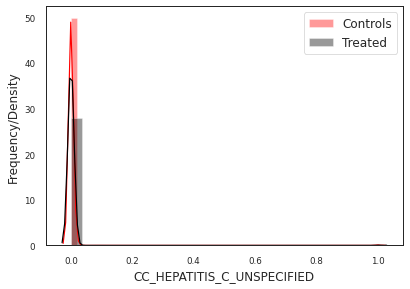

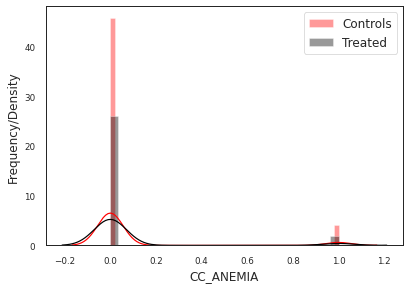

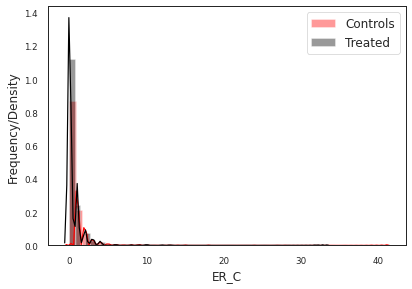

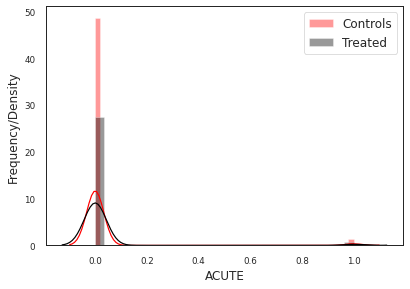

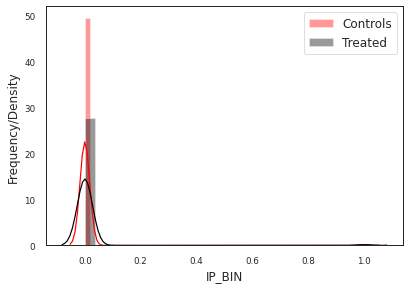

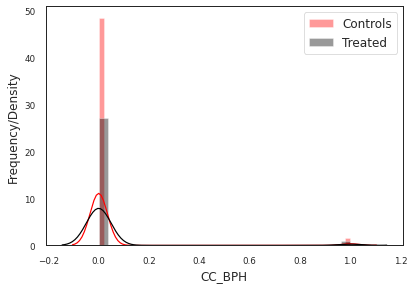

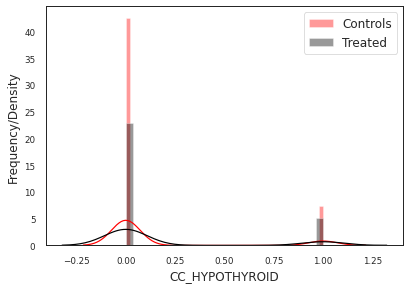

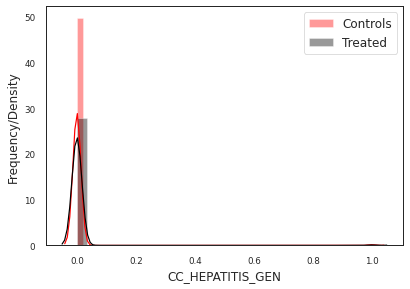

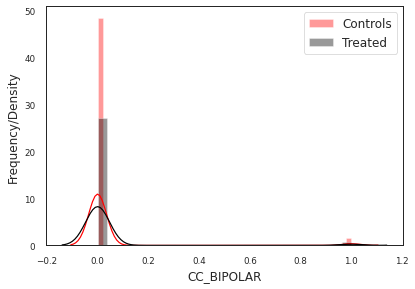

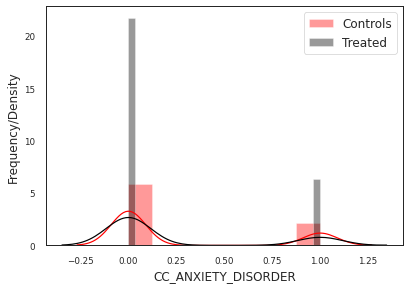

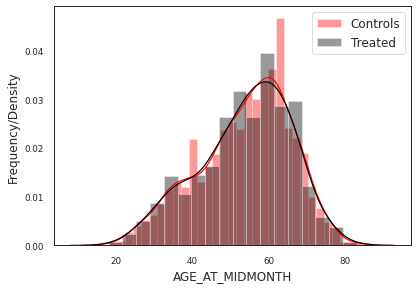

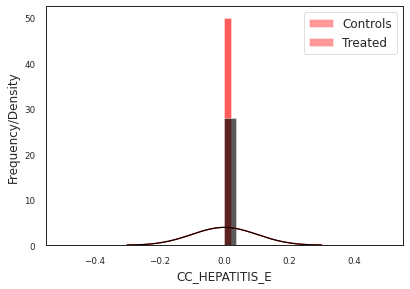

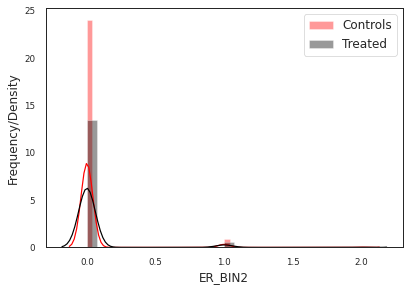

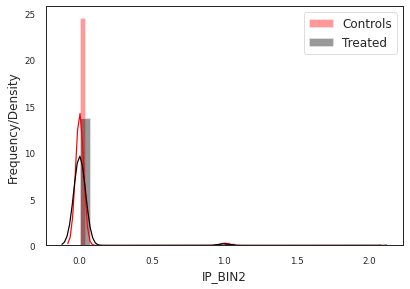

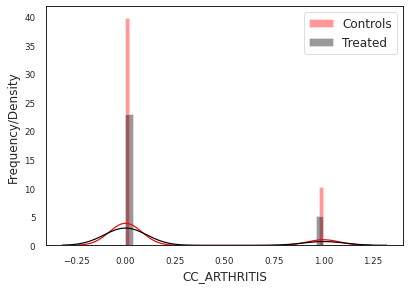

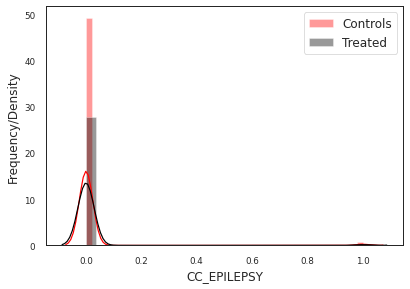

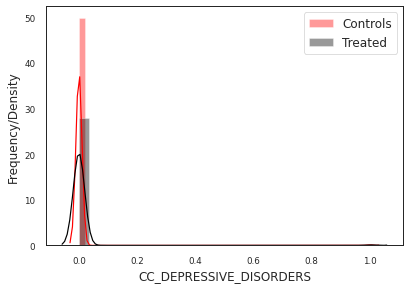

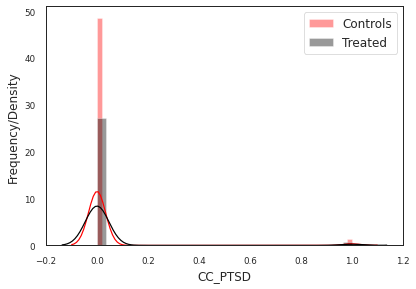

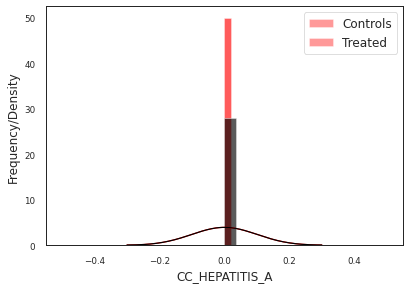

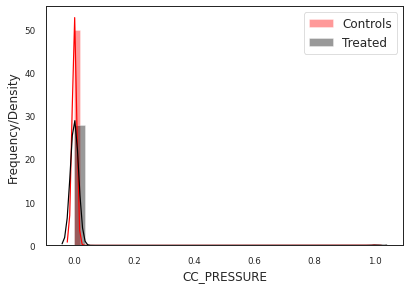

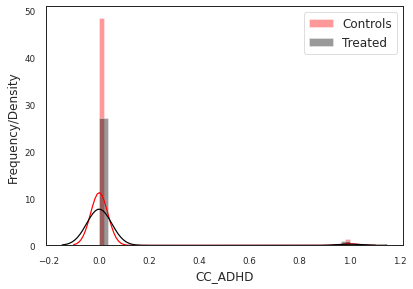

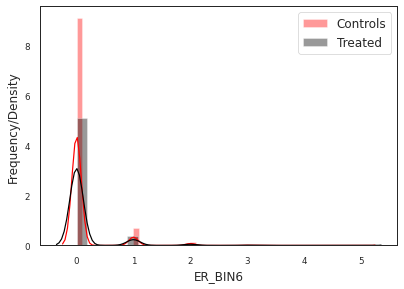

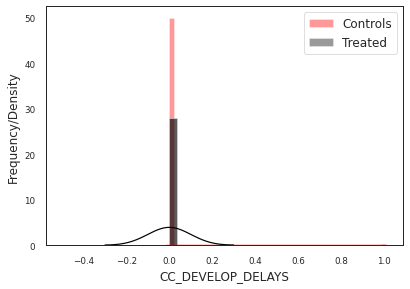

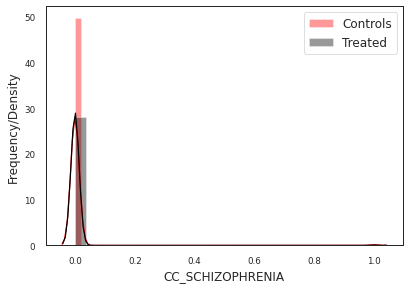

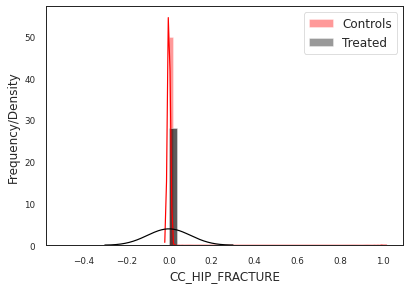

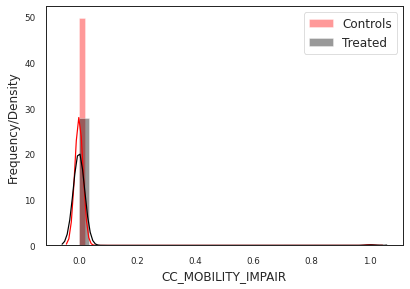

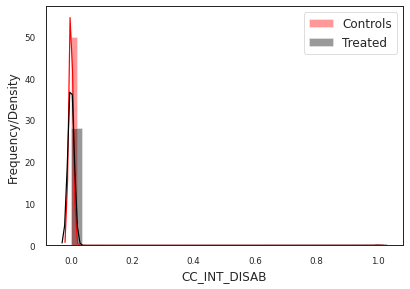

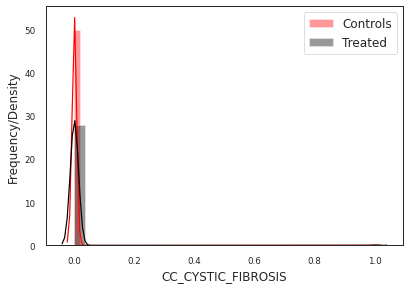

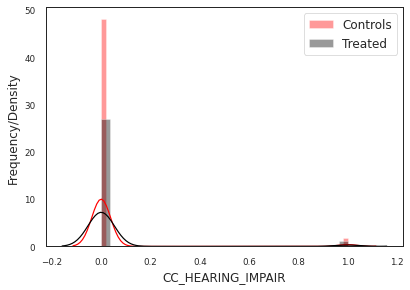

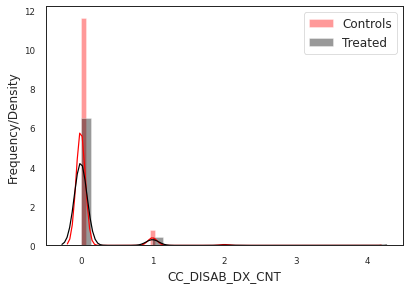

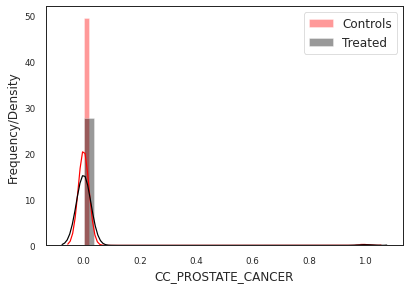

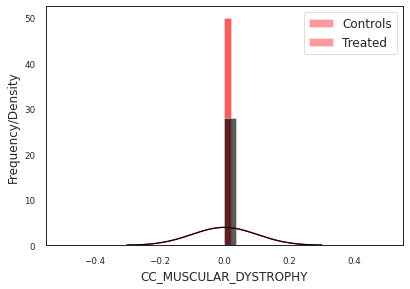

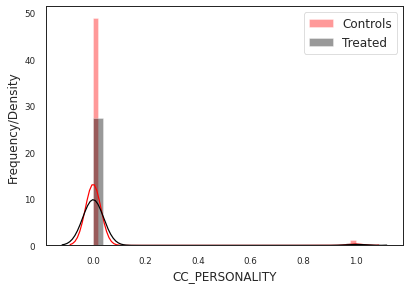

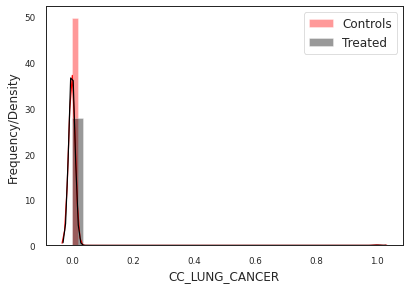

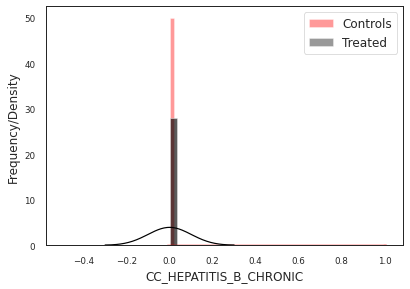

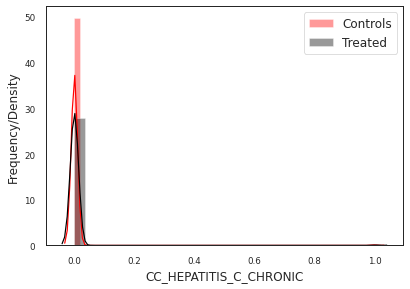

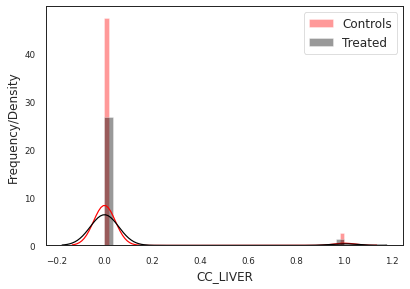

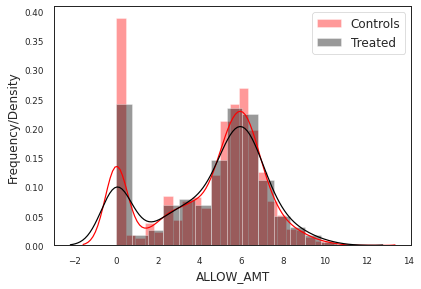

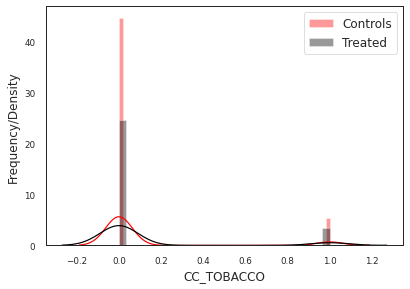

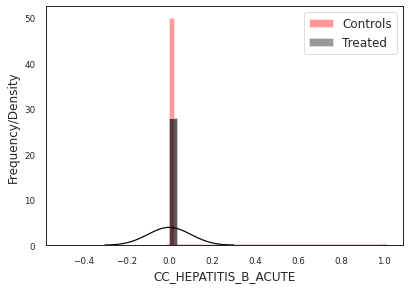

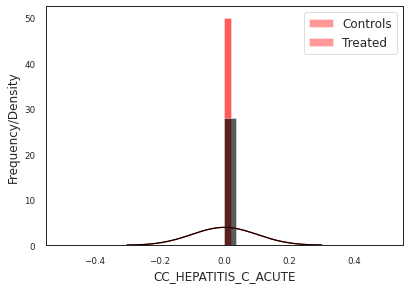

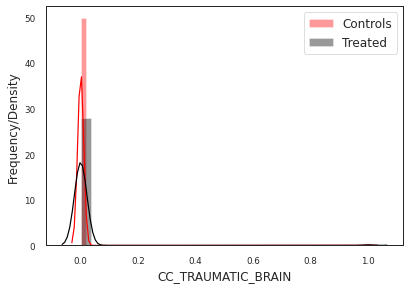

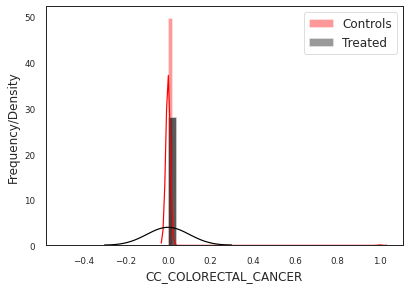

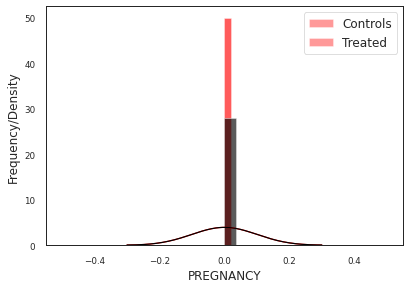

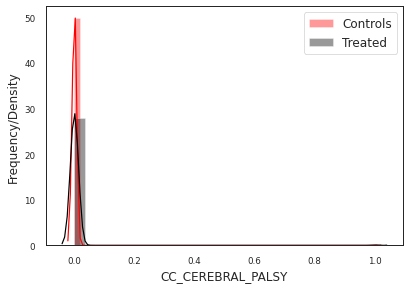

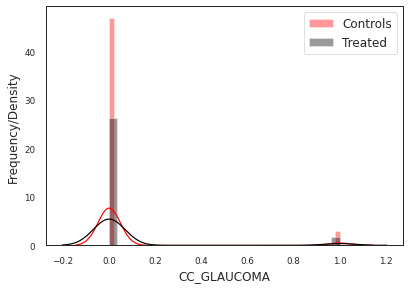

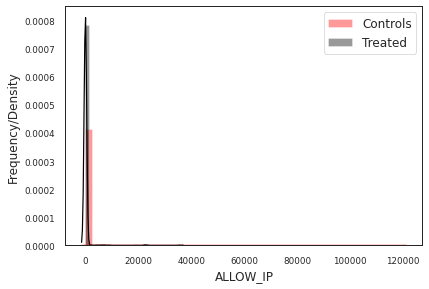

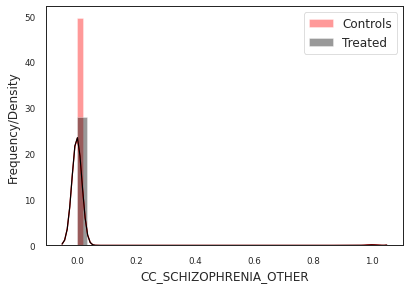

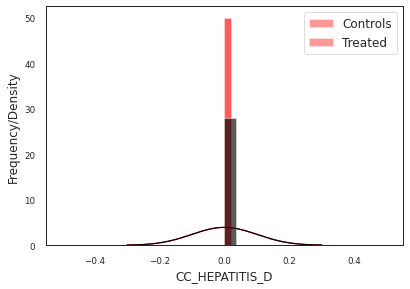

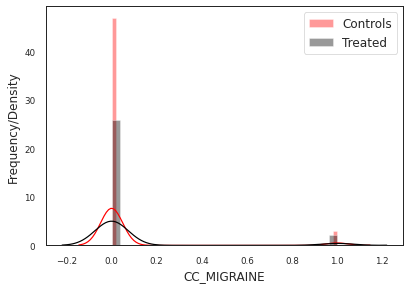

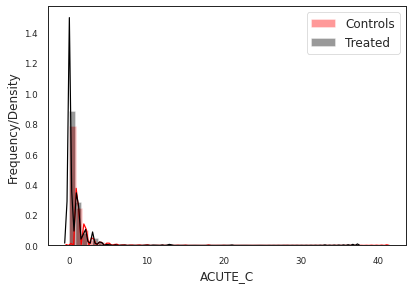

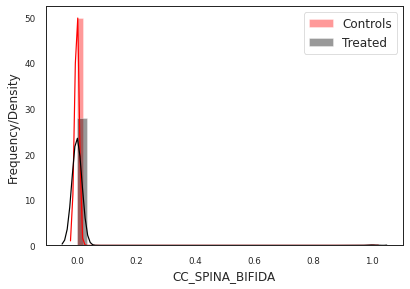

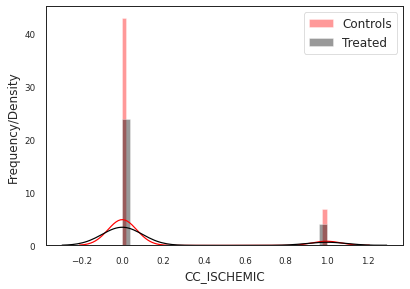

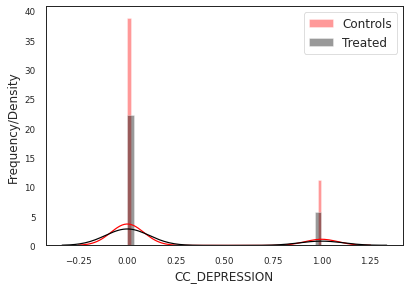

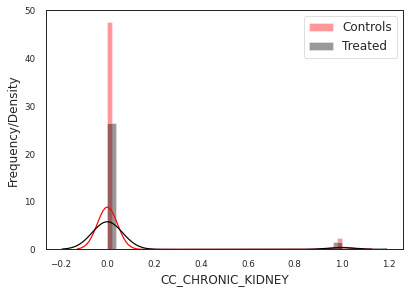

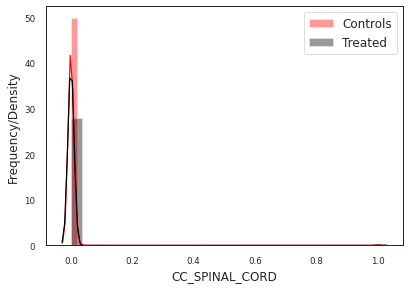

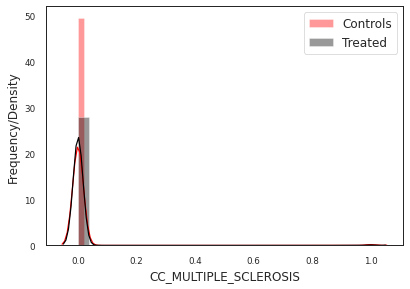

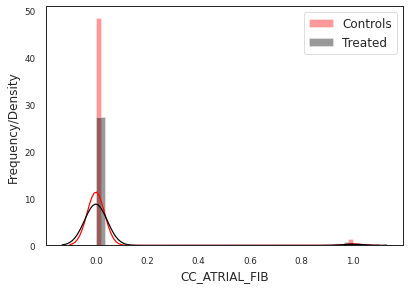

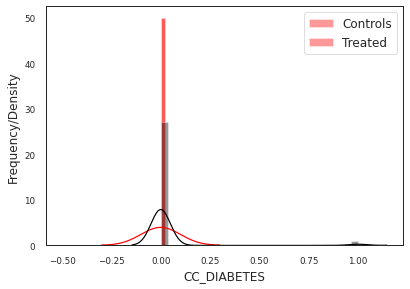

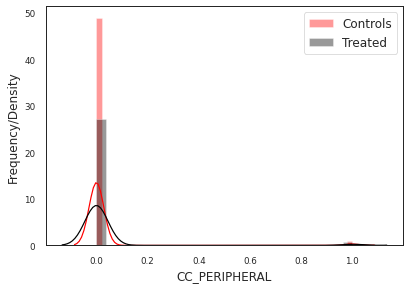

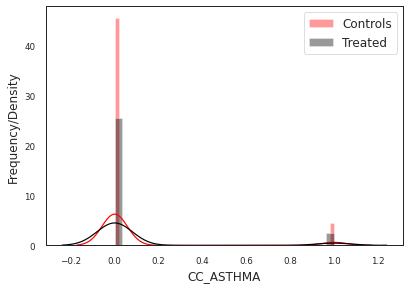

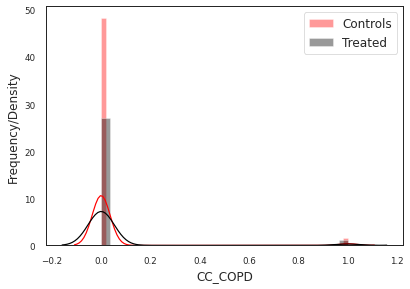

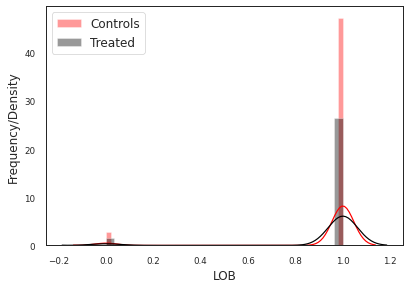

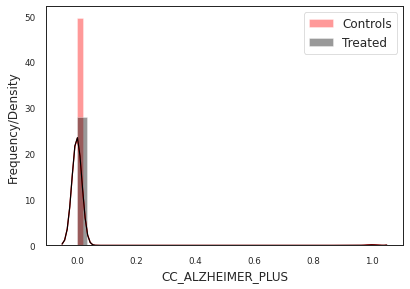

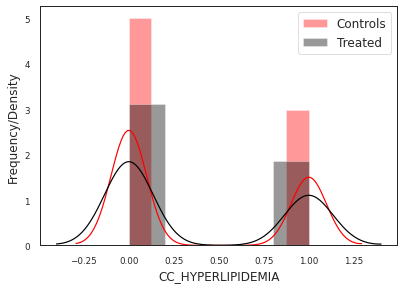

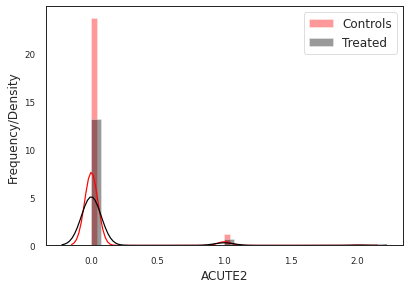

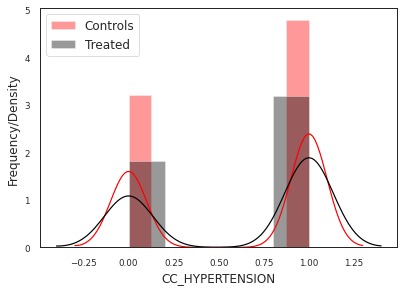

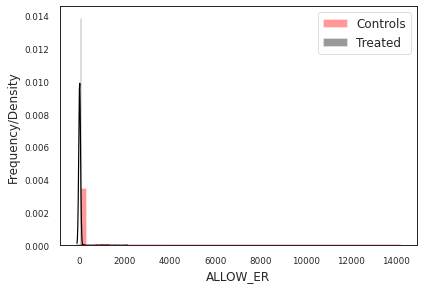

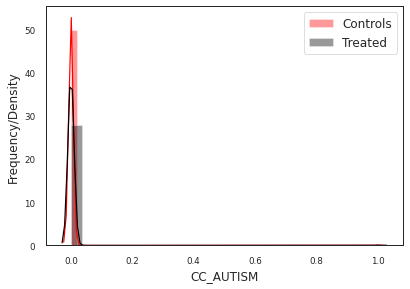

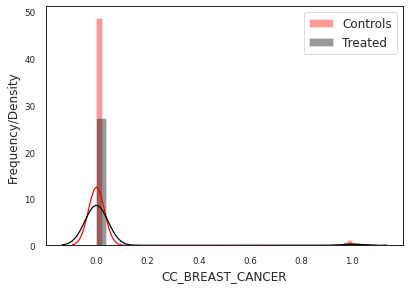

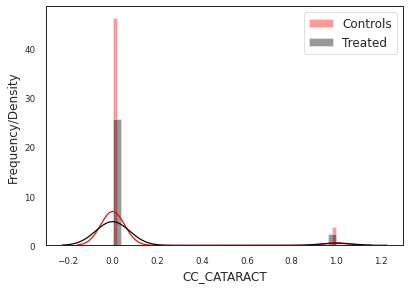

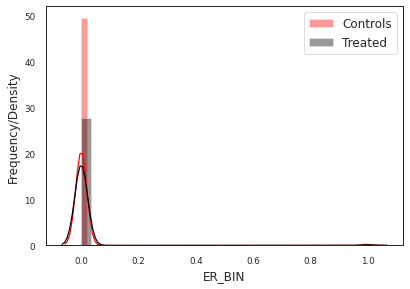

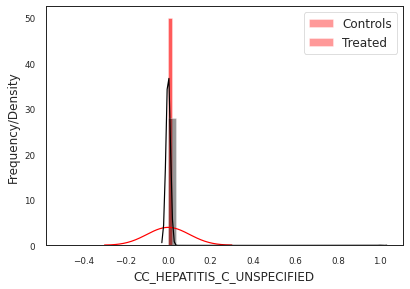

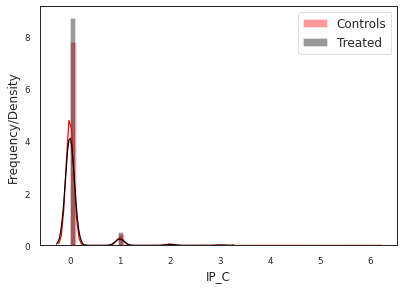

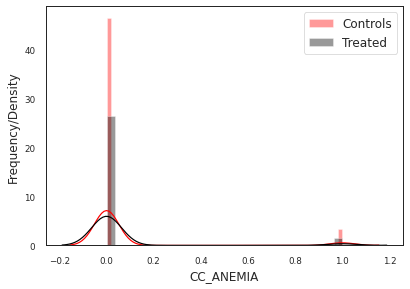

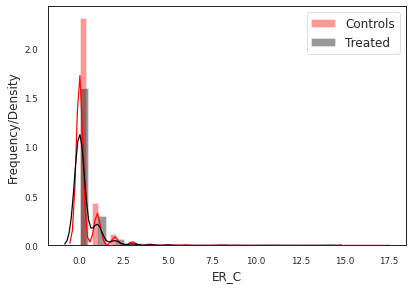

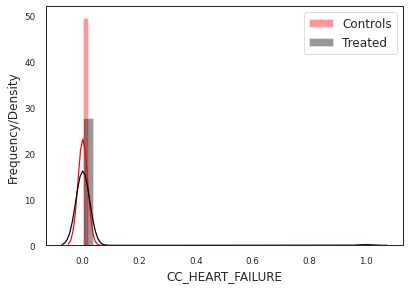

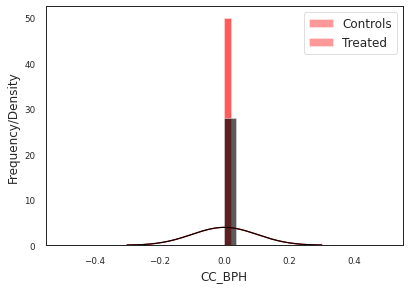

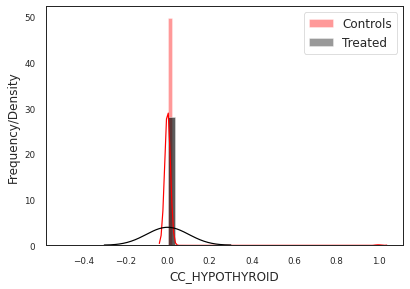

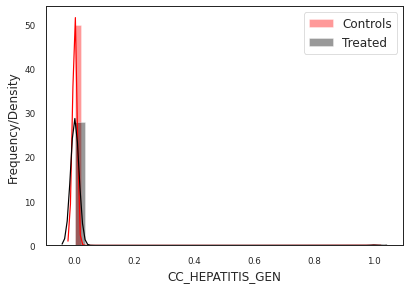

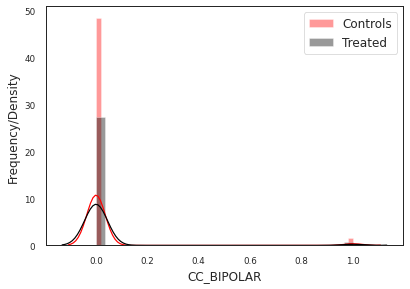

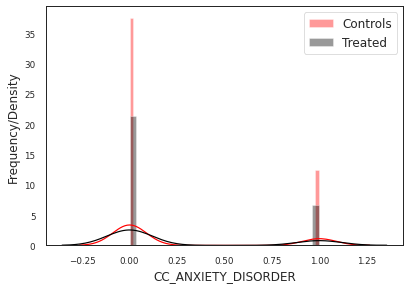

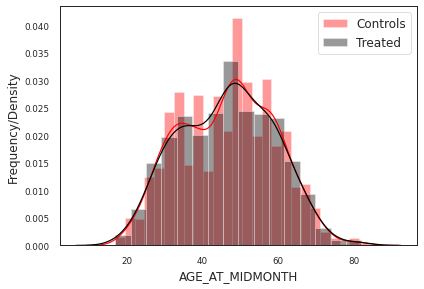

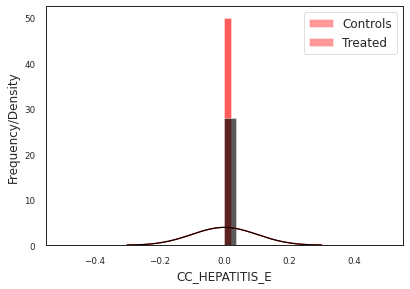

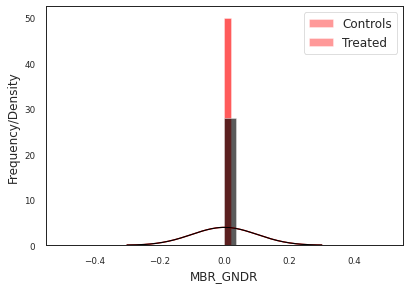

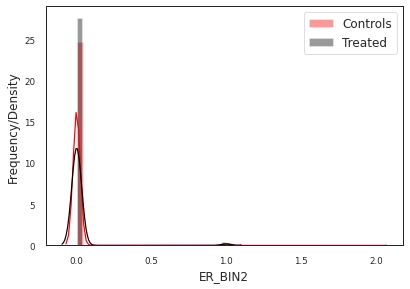

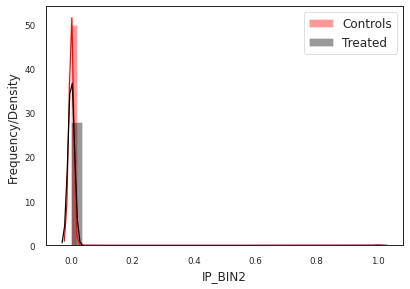

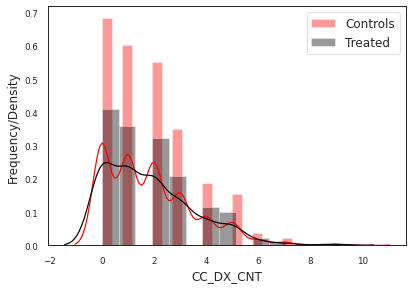

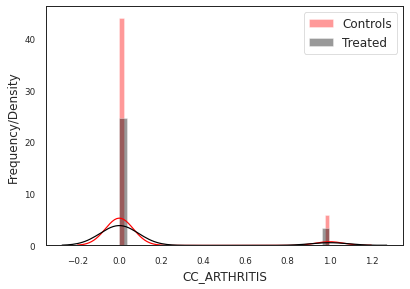

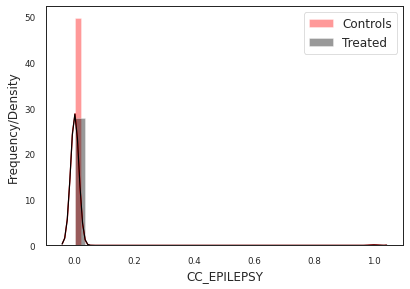

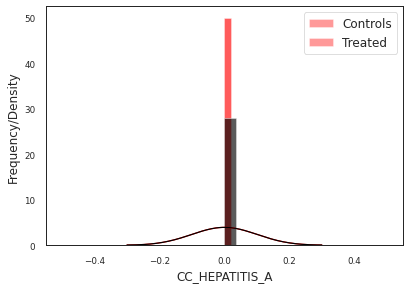

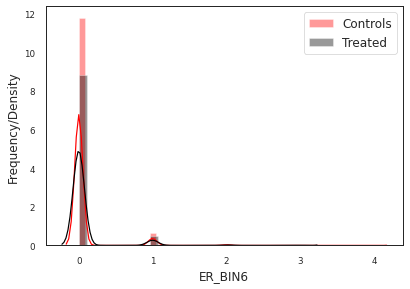

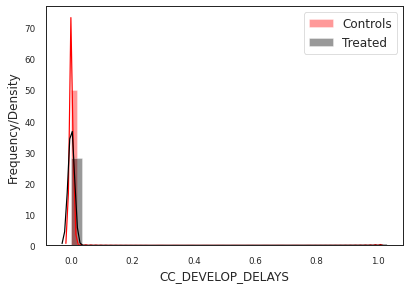

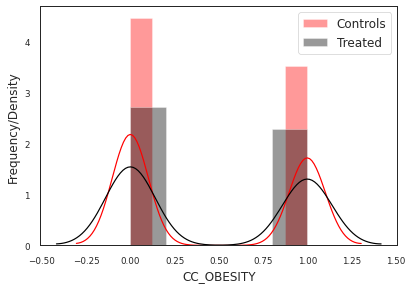

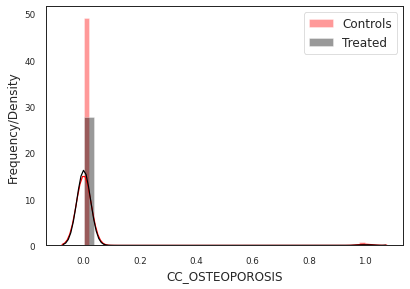

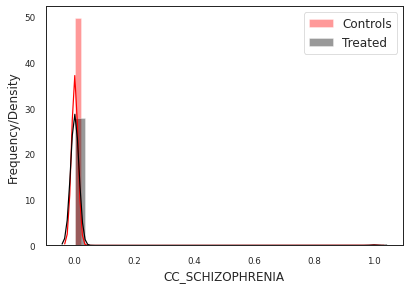

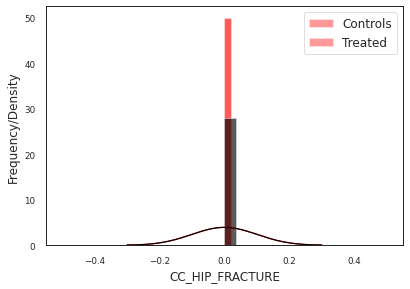

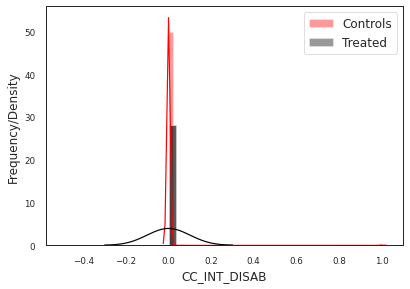

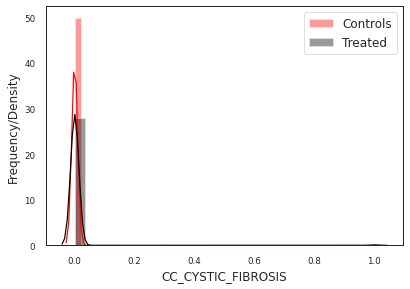

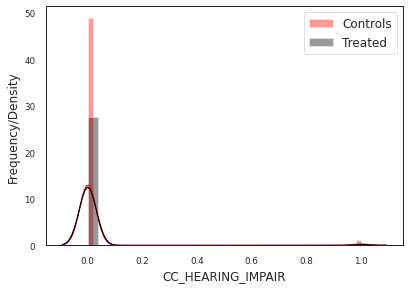

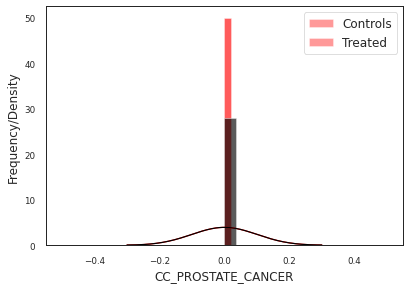

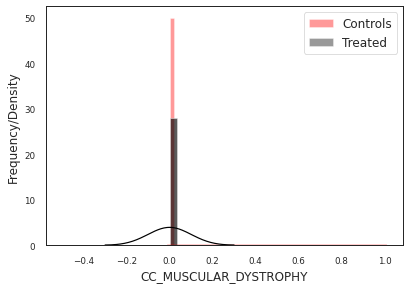

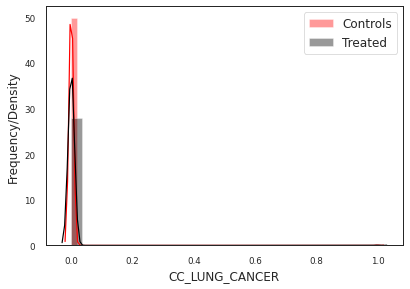

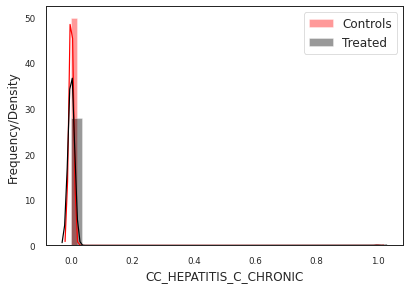

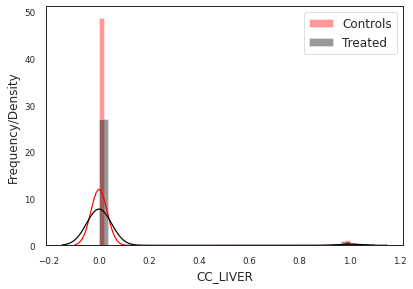

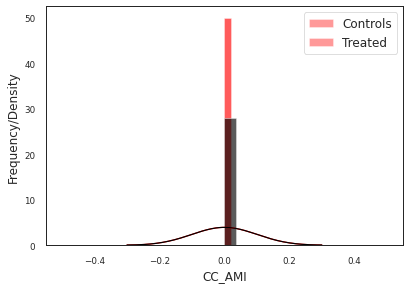

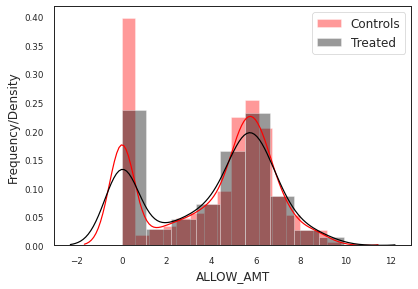

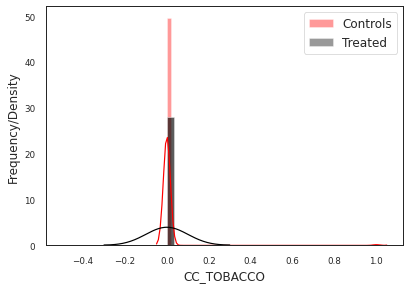

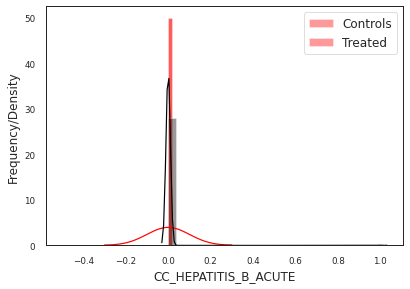

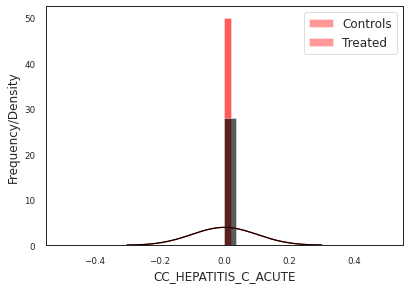

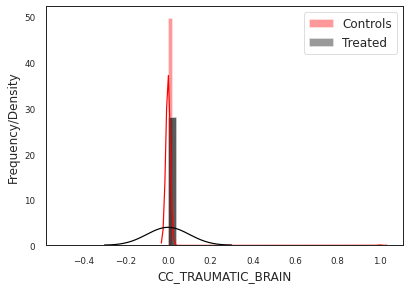

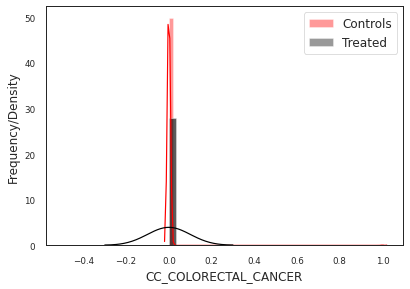

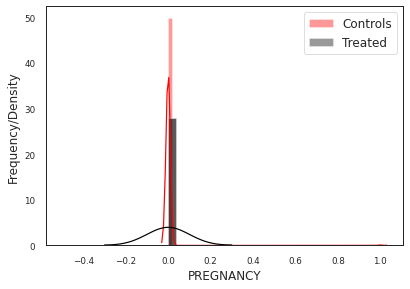

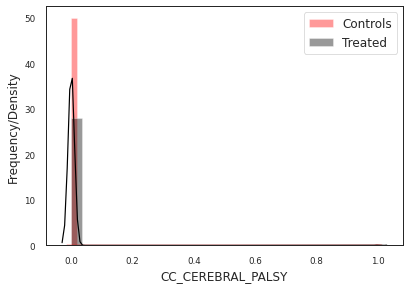

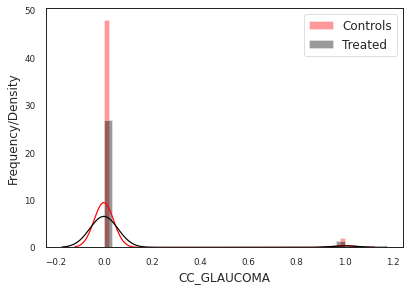

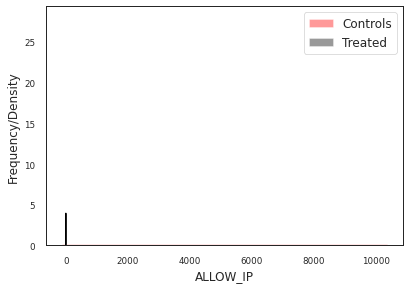

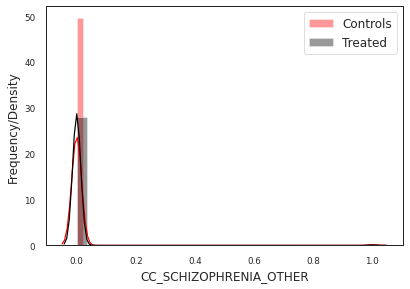

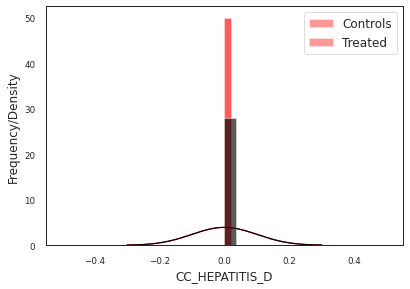

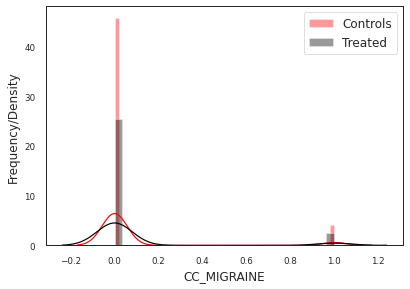

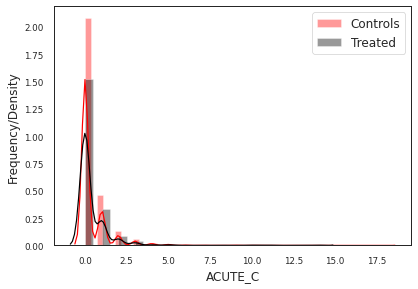

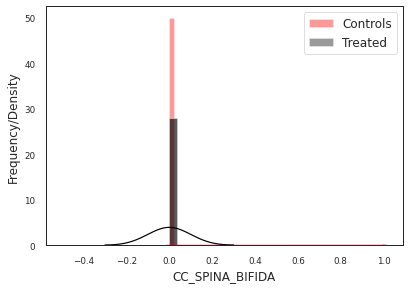

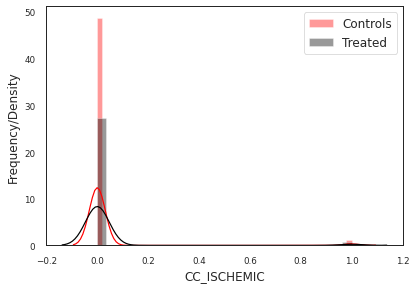

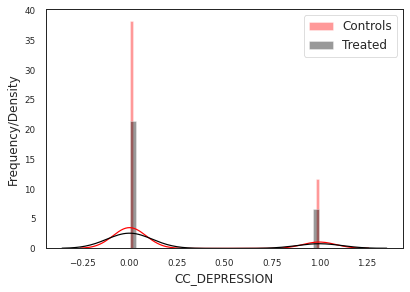

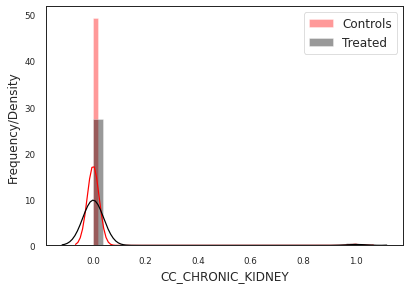

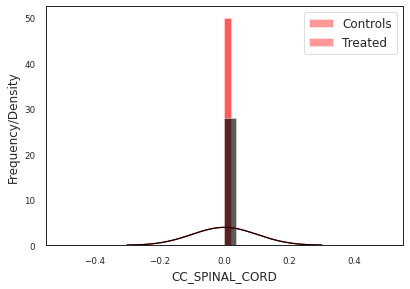

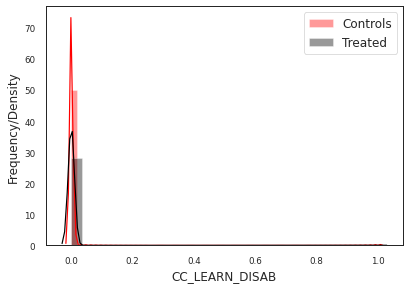

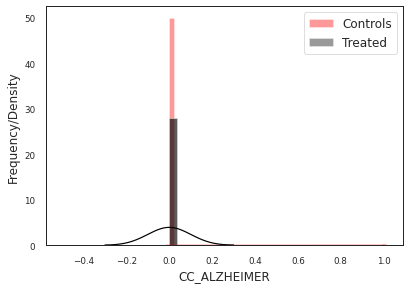

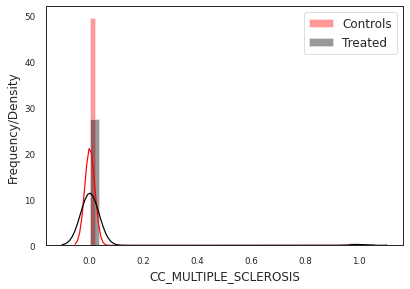

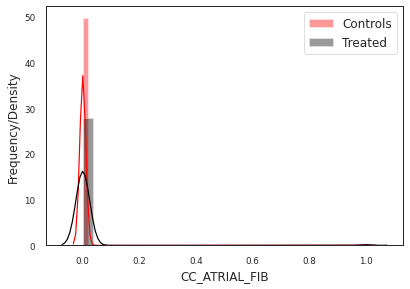

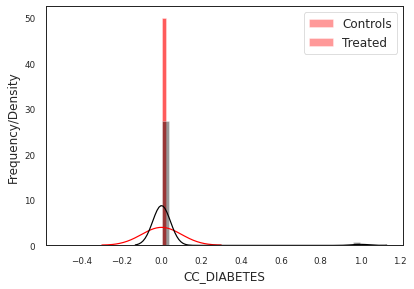

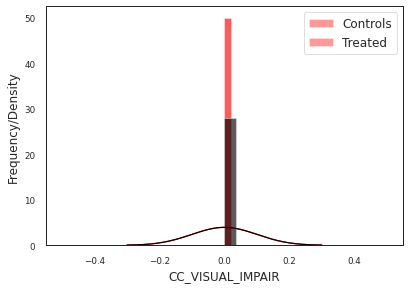

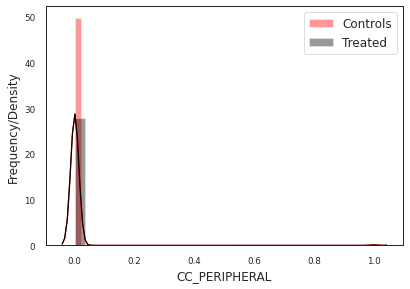

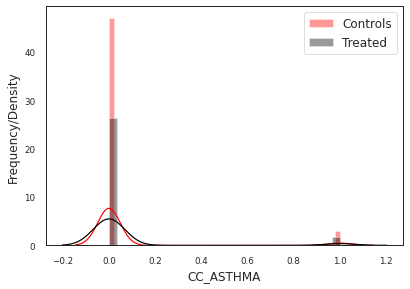

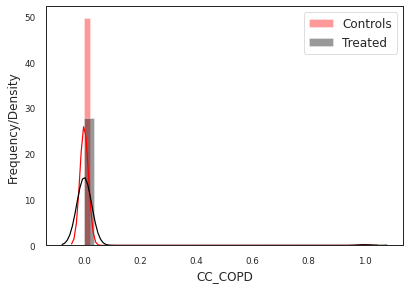

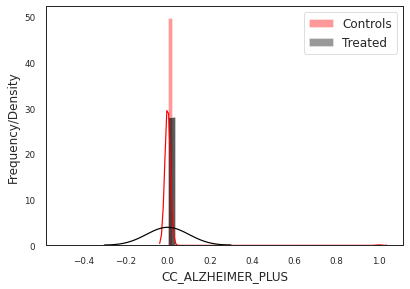

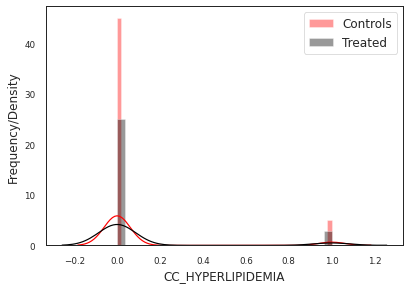

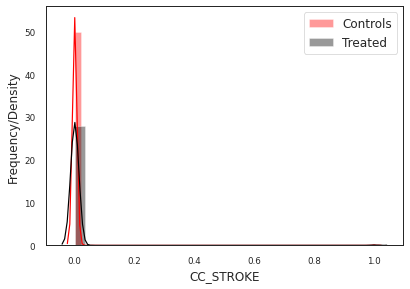

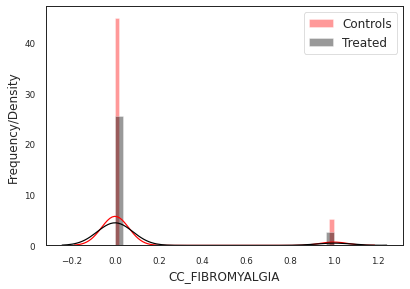

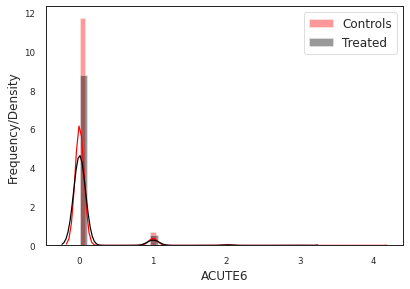

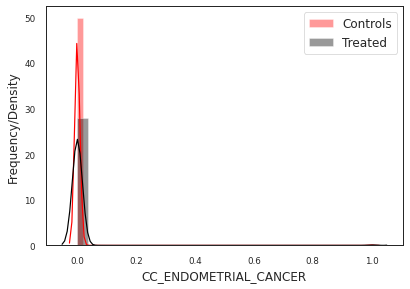

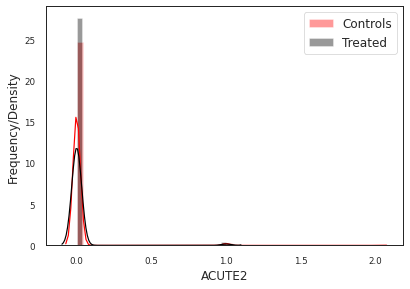

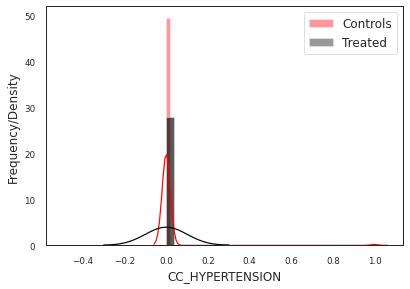

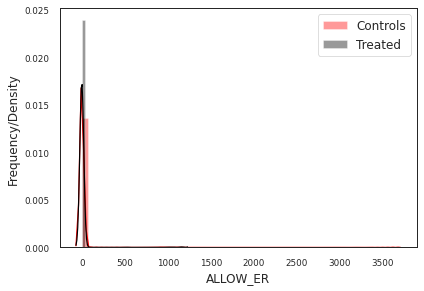

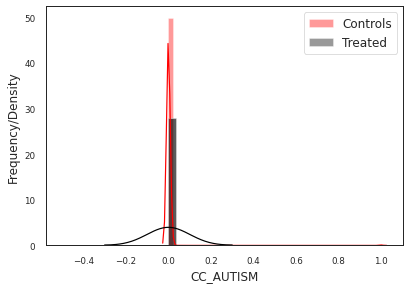

In [41]:
#%%capture

dist_plot_args = {'hist':True}
axes = plot_hist(treated_first_month0.copy(), 
                 controls_first_month0.copy(), mapping2, ['ALLOW_AMT'] , 
                 data3 = None, 
                 save_path = base_path+'figures0/distributions_all/',
                dist_plot_args = dist_plot_args)

dist_plot_args = {'hist':True}
axes = plot_hist(treated_first_month1.copy(), 
                 controls_first_month1.copy(), mapping2, ['ALLOW_AMT'] , 
                 data3 = None, 
                 save_path = base_path+'figures1/distributions_all/',
                dist_plot_args = dist_plot_args)

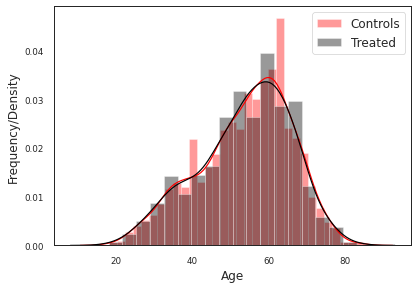

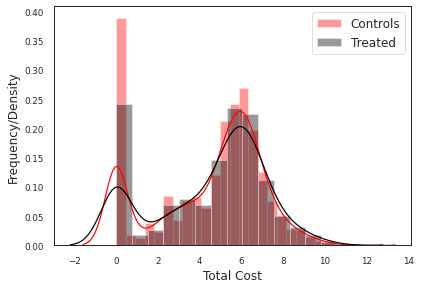

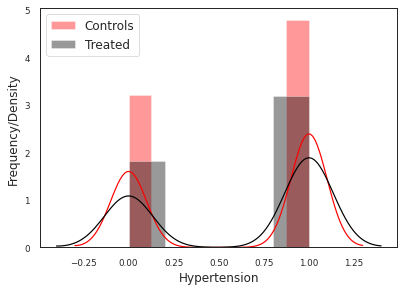

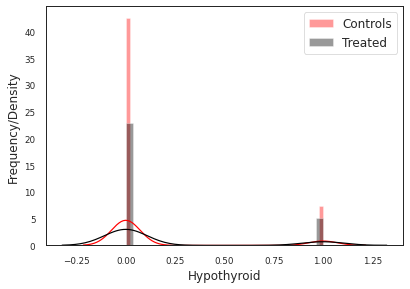

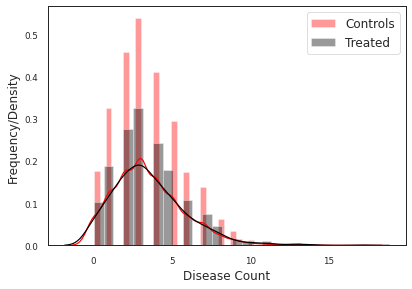

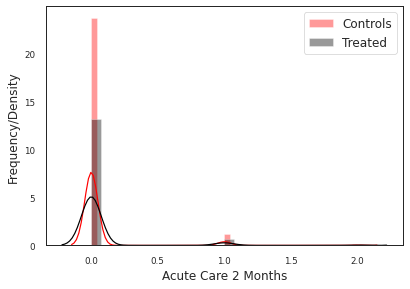

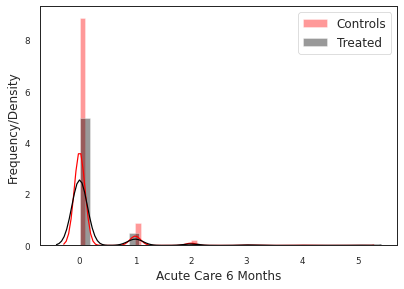

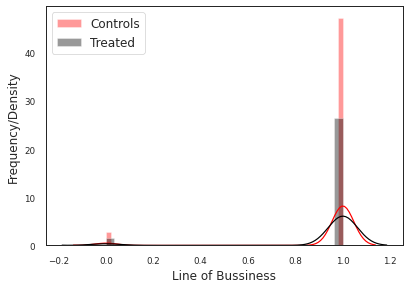

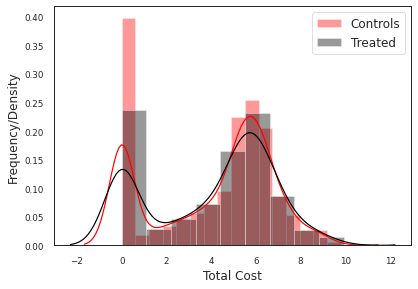

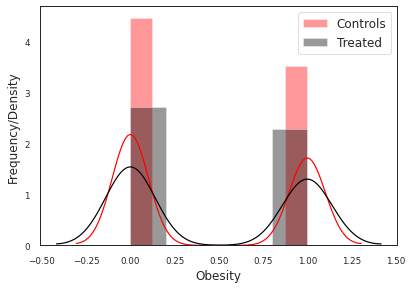

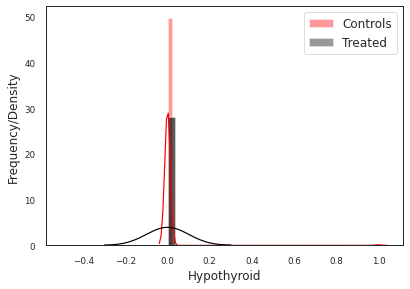

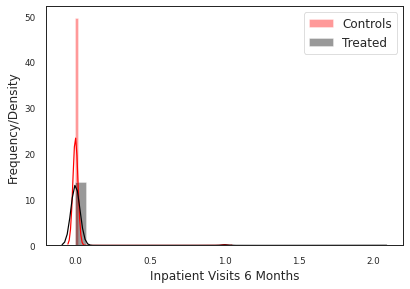

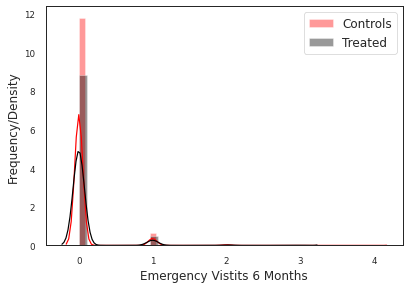

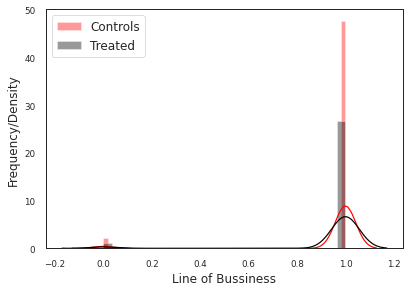

In [44]:
#%%capture
dist_plot_args = {'hist':True}
axes0 = plot_hist(treated_first_month0.copy(), 
                 controls_first_month0.copy(), mapping, ['ALLOW_AMT'] , 
                 data3 = None, 
                 save_path = base_path+'figures0/distributions_selection/',
                dist_plot_args = dist_plot_args)

dist_plot_args = {'hist':True}
axes1 = plot_hist(treated_first_month1.copy(), 
                 controls_first_month1.copy(), mapping, ['ALLOW_AMT'] , 
                 data3 = None, 
                 save_path = base_path+'figures1/distributions_selection/',
                dist_plot_args = dist_plot_args)

### Save enhanced stats arrays(these will be used at the end)
Arrays with: Statistics in first day, statistics  in the span of monthsm statistiocs from selected columns and all columns

In [43]:
arrays0 = [conds_first0, full_first0, conds_firstAllCols0, full_firstAllCols0,
         conds0, full0, conds_AllCols0, full_AllCols0]
arrays1 = [conds_first1, full_first1, conds_firstAllCols1, full_firstAllCols1,
         conds1, full1, conds_AllCols1, full_AllCols1]

names = ['conds_first', 'full_first', 'conds_firstAllCols', 'full_firstAllCols',
         'conds', 'full', 'conds_AllCols', 'full_AllCols']

names0 = [ nam+str(0) for nam in names]
names1 = [ nam+str(1) for nam in names]

save_arrays2(arrays0, names0, base_path+'tables0/stats/')
save_arrays2(arrays1, names1, base_path+'tables1/stats/')